In [170]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import math
from matplotlib.pyplot import cm

In [259]:
def get_data():  
    t = 2
    t1 = 10 * np.random.random_sample(100 * t) - 0.50
    t0 = np.random.normal(0, 0.40, 100 * t)
    x1 = np.vstack((t0, t1)).T
    y1 = np.ones(100 * t)
    
    t1 = 6 * np.random.random_sample(100 * t) - 0.50
    t0 = np.random.normal(0, 0.50, 100 * t)
    x2 = np.vstack((t1, t0)).T
    y2 = np.zeros(100 * t)
    
    mean = [3.50, 8.00]
    sigma = 0.50
    cov = sigma * np.identity(2)
    n3 = 50 * t
    x3 = np.random.multivariate_normal(mean, cov, n3)
    y3 = np.zeros(n3)
    
    X = np.concatenate((x1, x2, x3), axis=0)
    y = np.concatenate((y1, y2, y3))
    
    return X, y

np.random.seed(123)

X, y= get_data()

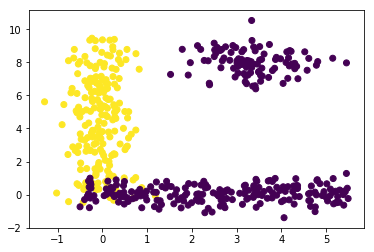

In [260]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

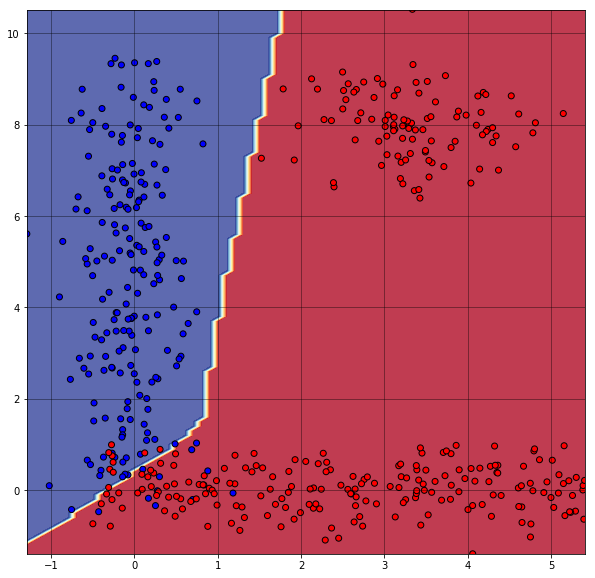

In [261]:
# Train a classifier
from sklearn.neural_network import MLPClassifier as NN
predictor = NN(max_iter=int(1e6))
predictor.fit(X, y)

h = 0.1
V = X
xmin, ymin = np.min(V, axis=0)
xmax, ymax = np.max(V, axis=0)

xx, yy = np.meshgrid(np.arange(xmin, xmax, h),
                     np.arange(ymin, ymax, h))

# cm = plt.cm.Blues
cm_bright = mpl.colors.ListedColormap(['#FF0000', '#0000FF'])    

newx = np.c_[xx.ravel(), yy.ravel()]

cm1 = plt.cm.RdYlBu

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

Z = predictor.predict(newx).reshape(xx.shape)

contour_plot = ax.contourf(xx, yy, Z, levels=20, cmap=cm1, alpha=.8)
ax.scatter(X[:, 0], X[:, 1], c=y,cmap=cm_bright, edgecolors='k', zorder=1)
ax.grid(color='k', linestyle='-', linewidth=0.50, alpha=0.75)

In [356]:
# Parameters
method = 'knn' # ['knn', 'kde', 'gs', 'egraph']
howmanypaths = 5
weight_function = lambda x: -np.log(x)
prediction_threshold = 0.75
density_threshold = 1e-5
K = 10
epsilon = 0.75
radius_limit = 1.10
n_neighbours = 20
distance_threshold = 0.35
n_samples = X.shape[0]
n_features = X.shape[1]
predictions = predictor.predict_proba(X)
edge_conditions = None

In [357]:
def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

def check_conditions(v0, v1):
        if edge_conditions is None:
            return True
        else:
            return edge_conditions(v0, v1)

def get_weights_kNN():
    volume_sphere = get_volume_of_sphere(n_features)
    const = (n_neighbours / (n_samples * volume_sphere))**(1/n_features)
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        counter = 0
        for j in range(n_samples):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if (check_conditions(v0, v1) and dist <= distance_threshold):
                k[i, j] = distance_threshold # Why not dist?
            else:
                counter += 1
        t = np.argsort(k[i, :])[1+counter+n_neighbours:]
        mask = np.ix_(t)
        k[i, mask] = 0

    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(n_samples):
            v1 = X[j, :].reshape(-1, 1)
#             if k[i, j] != 0:
#                 current_value = k[i, j]
#                 k[i, j] = current_value * weight_function(const/(current_value**n_features))
    return k

def modify_kernel(self):
    personal_kernel = self.kernel.copy()
    for i in range(self.n_samples):
        v0 = self.X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = self.X[j, :].reshape(-1, 1)

            if not self.check_individual_conditions(v0, v1):                   
                personal_kernel[i, j] = 0
                personal_kernel[j, i] = 0
    return personal_kernel

def get_edges(kernel):
    edges = []
    n_samples = kernel.shape[0]
    for i in range(n_samples):
        for j in range(n_samples):
            if kernel[i, j] != 0:
                edges.append([i, j, kernel[i, j]])
    return edges

kernel = get_weights_kNN()
edges = get_edges(kernel)

In [358]:
from collections import defaultdict
class Graph():
    def __init__(self, undirected=True):
        self.edges = defaultdict(list)
        self.weights = {}
        self.undirected = undirected
    
    def add_edge(self, from_node, to_node, weight):
        self.edges[from_node].append(to_node)
        self.weights[(from_node, to_node)] = weight
        if self.undirected:
            self.edges[to_node].append(from_node)
            self.weights[(to_node, from_node)] = weight

In [359]:
graph = Graph(undirected=False)
for edge in edges:
    graph.add_edge(*edge)

In [360]:
# Now compute path
start_point_index = 0
start_point = X[start_point_index]
original_class = y[start_point_index]
target_class = 0.0
individual_edge_conditions = None

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


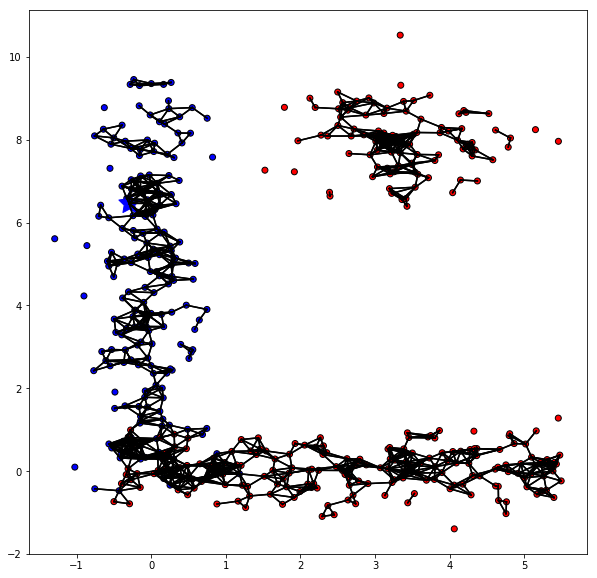

In [361]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], c=y,cmap=cm_bright, edgecolors='k', zorder=1)
for i in range(len(graph.edges)):
    edge_temp = graph.edges[i]
    for e in edge_temp:
        ax.plot([X[i, 0], X[e, 0]], [X[i, 1], X[e, 1]], c='k')
ax.scatter(start_point[0],start_point[1], marker=(5, 1), s=500, cmap=cm_bright, c=cm_bright(original_class))

In [362]:
t0 = np.where(predictions >= prediction_threshold)[0]
y_pred = predictor.predict(X)
t1 = np.where(y_pred == target_class)[0]
candidate_targets = list(set(t0).intersection(set(t1)))

In [364]:
from functools import partial

def condition(item):
    pred = predictions[item, int(y[item])]
    return (pred), True

def return_value(dictionary, key, path=[]):
    try:
        val = dictionary[key]
        path.append(val)
        return return_value(dictionary, val, path)
    except:
        return path[::-1]

def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return -1 #"Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    dist = 0
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        if next_node:
            dist += graph.weights[(current_node, next_node)]
        current_node = next_node
        
    # Reverse path
    path = path[::-1]
    return dist, path

def dijsktra_toall(graph, initial):
    edges = graph.edges
    weights = graph.weights
    
    nodes_status = {item: [math.inf, 'T'] for item in edges.keys() if item != initial}
    nodes_status[initial] = [0, 'P']
    previous_nodes = {}
    current_node = initial

    while True:
        distance_to_current_node = nodes_status[current_node][0]
        neighbours = edges[current_node]
        for neighbour in neighbours:
            if (current_node, neighbour) in weights.keys():
                if (neighbour in nodes_status.keys() and nodes_status[neighbour][1] == 'T'):
                    current_distance = nodes_status[neighbour][0]
                    traversal_cost = weights[(current_node, neighbour)]
                    proposed_distance = distance_to_current_node + traversal_cost
                    if proposed_distance < current_distance:
                        nodes_status[neighbour][0] = proposed_distance
                        previous_nodes[neighbour] = current_node
        filtered_weights = {item: value[0] for item, value in nodes_status.items() if value[1] == 'T'}
        if not filtered_weights:
            break
        best_node = min(filtered_weights, key=filtered_weights.get)
        nodes_status[best_node][1] = 'P'
        current_node = best_node
    paths = {item: return_value(previous_nodes, item, [item]) for item in previous_nodes.keys()}
    return nodes_status, paths

def dijsktra_tosome(graph, initial, targets):
    paths = {}; dists = {}
    dijsktra_partial = partial(dijsktra, graph, initial)
    for target in targets:
        sat = dijsktra_partial(target)
        if sat != -1:
            dist, path = sat
            paths[target] = path
            dists[target] = dist
    return dists, paths

# from copy import deepcopy
# personal_kernel = modify_kernel(kernal)
# personal_graph = Graph()
# edges = get_edges(personal_kernel)
# for edge in edges:
#     personal_graph.add_edge(*edge)

dist, paths = dijsktra_tosome(graph, start_point_index, candidate_targets)
all_paths = []
for item, path in paths.items():
    value, satisfied = condition(item)
    all_paths.append((item, X[item, :], dist[item], value, path))
all_paths = sorted(all_paths, key=lambda x: x[2])

In [365]:
h = 0.1
V = X
xmin, ymin = np.min(V, axis=0)
xmax, ymax = np.max(V, axis=0)

xx, yy = np.meshgrid(np.arange(xmin, xmax, h),
                     np.arange(ymin, ymax, h))

# cm = plt.cm.Blues
cm_bright = mpl.colors.ListedColormap(['#FF0000', '#0000FF'])    

newx = np.c_[xx.ravel(), yy.ravel()]

cm1 = plt.cm.RdYlBu

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

Z = predictor.predict(newx).reshape(xx.shape)

contour_plot = ax.contourf(xx, yy, Z, levels=20, cmap=cm1, alpha=.8)
ax.scatter(X[:, 0], X[:, 1], c=y,cmap=cm_bright, edgecolors='k', zorder=1)
ax.grid(color='k', linestyle='-', linewidth=0.50, alpha=0.75)

def plot_path(path, ax, color='lightgreen', extra_point=None):
    V = X
    if n_features != 2:
        return 0
    n_nodes = len(path)
    if isinstance(extra_point, np.ndarray):
        ax.plot([X[-1, 0], extra_point[0]],
                [X[-1, 1], extra_point[1]],
                'k', alpha=0.50)
        ax.scatter(extra_point[0], extra_point[1],
                   color='k',
                   marker='o',
                   facecolors='lightyellow',
                   edgecolors='lightyellow',
                   alpha = 0.80,
                   zorder=1,
                   s=250)

    args = {'color': 'lightgreen',
            'marker': 'x',
            's': 100}
    for idx in range(n_nodes-1):
        i = int(path[idx])
        j = int(path[idx + 1])
        #ax.scatter(X[i, 0], X[i, 1], **args)
        ax.plot(V[[i, j], 0], V[[i, j], 1], 'k', alpha=0.50)

    ax.scatter(V[path[-1], 0], V[path[-1], 1],
               color='k',
               marker='o',
               facecolors=color,
               edgecolors=color,
               alpha = 0.50,
               zorder=2,
                   s=150)

def plot_paths(ax, all_paths):
    counter = 0
    colors=cm.Greens(np.linspace(0,1,howmanypaths))

    for idx, item in enumerate(all_paths):
        if counter > howmanypaths - 1:
                break
        path = item[-1]
        plot_path(path, ax, colors[counter])
        counter += 1

plot_paths(ax, all_paths)